In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.ticker as ticker
import numpy as np

from numba import njit, prange
import math

In [2]:
!tar xf dye_data.tar.gz

In [3]:
m_pos=pd.read_csv("dye_data/Live_coral_1/mouths_positions_Echinopora_Big_chunk.csv").loc[:,["X","Y"]]
bbox=[146, 350, 686, 1110]

m_pos=m_pos.iloc[(m_pos["X"]>bbox[0]).values & (m_pos["Y"]>bbox[1]).values & 
                 (m_pos["X"]<(bbox[0]+bbox[2])).values & (m_pos["Y"]<(bbox[1]+bbox[3])).values,:]
m_pos["X"]=m_pos["X"]-bbox[0]
m_pos["Y"]=m_pos["Y"]-bbox[1]

tiffs=glob.glob("dye_data/Live_coral_1/Out/*.tiff")
tiffs.sort()

mask= mpimg.imread(tiffs[0]) 
ii = np.argwhere(mask)

coord1=m_pos.values
coord1=coord1.astype(int)
coord2=ii[:,[1,0]]
#coord2=coord2.astype("int32")

In [4]:
@njit('void(int64[:,:], int64[:,:], int32[:,:])',parallel=True)
def cdist_numba_par(coord1,coord2,out):
    for i in prange(coord1.shape[0]):
        for j in range(coord2.shape[0]):
            out[i,j] = ((coord2[j,0] - coord1[i,0])**2+(coord2[j,1] - coord1[i,1])**2)
            
def overmouth_cpu(tiff):
    
    mask= mpimg.imread(tiff)
    ii = np.argwhere(mask)
    coord2=(ii[:,[1,0]])
    
    out_cpu= np.zeros((coord1.shape[0],coord2.shape[0]), dtype='int32')

    cdist_numba_par(coord1, coord2, out_cpu); \

    return np.amin(out_cpu,axis=1)

In [5]:
m_pos=pd.read_csv("dye_data/Live_coral_1/mouths_positions_Echinopora_Big_chunk.csv").loc[:,["X","Y"]]
bbox=[146, 350, 686, 1110]

m_pos=m_pos.iloc[(m_pos["X"]>bbox[0]).values & (m_pos["Y"]>bbox[1]).values & 
                 (m_pos["X"]<(bbox[0]+bbox[2])).values & (m_pos["Y"]<(bbox[1]+bbox[3])).values,:]
m_pos["X"]=m_pos["X"]-bbox[0]
m_pos["Y"]=m_pos["Y"]-bbox[1]

tiffs=glob.glob("dye_data/Live_coral_1/Out/*.tiff")
tiffs.sort()

In [6]:
allmin_1=list(map(overmouth_cpu,tiffs))

argsmouths=(pd.DataFrame(allmin_1)<3).apply(lambda x: np.argwhere(x.values),axis=1)
n_1=[len(argsmouths[0][:,0])]
m_1=list(map(len,argsmouths))
temp=argsmouths[0][:,0]

for i in range(1,len(tiffs)-1):
    temp=np.unique(np.concatenate((temp,argsmouths[i][:,0])))
    n_1=n_1+[len(temp)]

In [7]:
m_pos=pd.read_csv("dye_data/Live_coral_2/mouths_positions_Echinopora_Big_chunk_2.csv").loc[:,["X","Y"]] 

tiffs=glob.glob("dye_data/Live_coral_2/Out/*.tiff")
tiffs.sort()
allmin_2=list(map(overmouth_cpu,tiffs))

argsmouths=(pd.DataFrame(allmin_2)<3).apply(lambda x: np.argwhere(x.values),axis=1)
m_2=list(map(len,argsmouths))
n_2=[len(argsmouths[0][:,0])]
temp=argsmouths[0][:,0]

for i in range(1,len(tiffs)-1):
    temp=np.unique(np.concatenate((temp,argsmouths[i][:,0])))
    n_2=n_2+[len(temp)]

In [8]:
m_pos=pd.read_csv("dye_data/live_coral_3/mouths_positions_Echinopora_Big_chunk_3.csv").loc[:,["X","Y"]] 

tiffs=glob.glob("dye_data/live_coral_3/Out/*.tiff")
tiffs.sort()
allmin_3=list(map(overmouth_cpu,tiffs))

argsmouths=(pd.DataFrame(allmin_3)<3).apply(lambda x: np.argwhere(x.values),axis=1)
m_3=list(map(len,argsmouths))
n_3=[len(argsmouths[0][:,0])]
temp=argsmouths[0][:,0]

for i in range(1,len(tiffs)-1):
    temp=np.unique(np.concatenate((temp,argsmouths[i][:,0])))
    n_3=n_3+[len(temp)]

In [9]:
len(np.arange(0,len(m_2)*5+5,5))

19

In [10]:
df=pd.DataFrame({"time":np.arange(0,len(m_1)*5,5),
              "n1":m_1,"n2":m_2[:17],"n3":m_3})

In [11]:
df.to_csv("dye_analysis.csv")

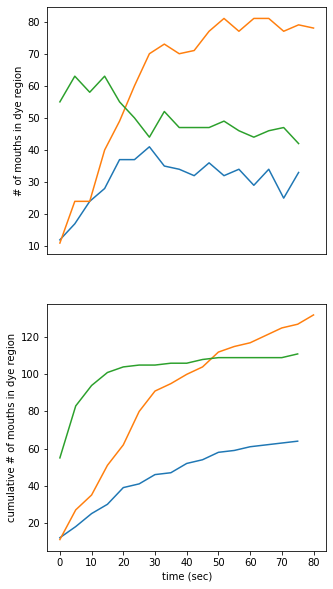

In [12]:
fig = plt.figure(figsize=(5,10))
ax1 = fig.add_subplot(211)
ax1.plot(range(len(m_1)),m_1)
ax1.plot(range(len(m_2)),m_2)
ax1.plot(range(len(m_3)),m_3)
plt.xticks([])
plt.ylabel("# of mouths in dye region")
ax2 = fig.add_subplot(212)
ax2.plot(range(len(n_1)),n_1)
ax2.plot(range(len(n_2)),n_2)
ax2.plot(range(len(n_3)),n_3)
plt.xlabel("time (sec)")
plt.ylabel("cumulative # of mouths in dye region")
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*5))
ax2.xaxis.set_major_formatter(ticks_x)

plt.savefig("macro_dynamics.svg")